In [14]:
import numpy as np
import matplotlib.pyplot as plt
from utils.image_audio import play_sound, show_image, load_sound, show_image_mpl, load_image_gray
from utils.matrices import show_boxed_tensor_latex, print_matrix
%matplotlib inline

In [15]:
# and IPython.display for audio output
import IPython.display

# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

In [16]:
#y, sr=load_sound("E:/one.wav")

#ffmpeg -i onet.mp3 -acodec pcm_u8 -ar 22050 onet.wav
y, sr = librosa.load("E:/onet.mp3")

yy, srr = librosa.load("E:/Waka.mp3")
#AudioSegment.from_mp3("E:/onet.mp3")
#from pydub import AudioSegment
#wav_audio = AudioSegment.from_wav("E:/one.wav")

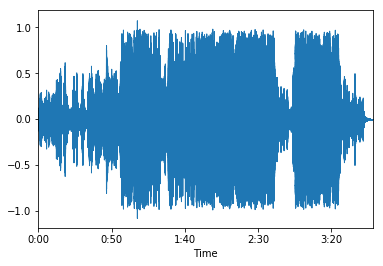

In [5]:
librosa.display.waveplot(y)

[[1.93536515e-09 1.51422987e-09 7.92025934e-10 ... 9.46956197e-10
  1.49715783e-09 1.90016286e-09]
 [3.68331838e-10 2.58598340e-10 1.03875573e-09 ... 7.81344469e-10
  1.13525908e-09 7.63719823e-10]
 [5.54830128e-10 4.15420972e-10 8.44418454e-10 ... 1.64184152e-09
  1.42807953e-09 1.49583951e-09]
 ...
 [1.05611143e-08 1.05519883e-08 1.43482096e-08 ... 1.58529846e-08
  1.43497870e-08 9.87471616e-09]
 [7.06469986e-09 4.80190674e-09 5.05081757e-09 ... 5.54691642e-09
  5.65692469e-09 4.33401250e-09]
 [4.44773237e-10 4.27760672e-10 2.62949888e-10 ... 3.49776789e-10
  6.40448204e-10 6.27945894e-10]]
[[-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]
 ...
 [-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]]


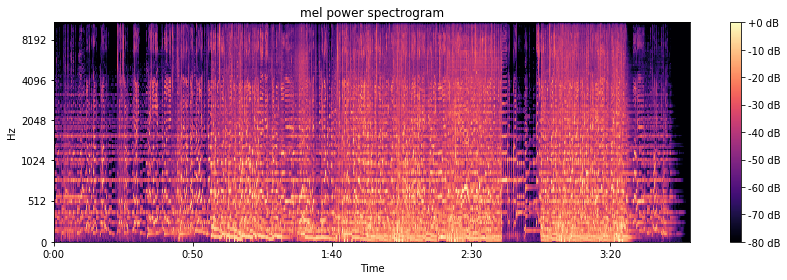

In [7]:
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

print(S)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)
print(log_S)
# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color ba
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

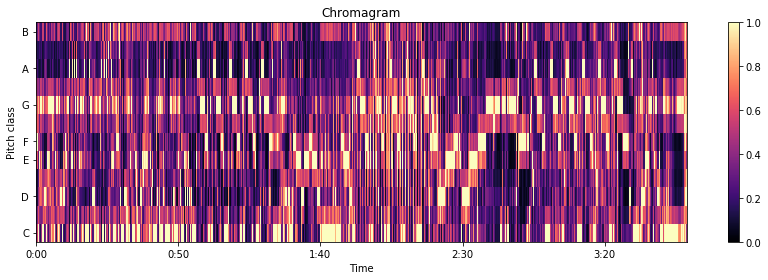

In [7]:
# We'll use a CQT-based chromagram here.  An STFT-based implementation also exists in chroma_cqt()
# We'll use the harmonic component to avoid pollution from transients
C = librosa.feature.chroma_cqt(y, sr=sr)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the chromagram: the energy in each chromatic pitch class as a function of time
# To make sure that the colors span the full range of chroma values, set vmin and vmax
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)

plt.title('Chromagram')
plt.colorbar()

plt.tight_layout()

(13, 9856)


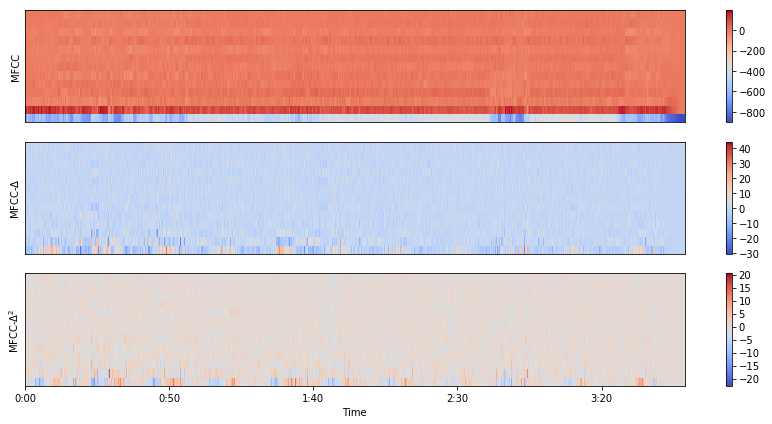

In [10]:
# Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

print (mfcc.shape)

# How do they look?  We'll show each in its own subplot
plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

# For future use, we'll stack these together into one matrix
M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

<Figure size 864x432 with 0 Axes>

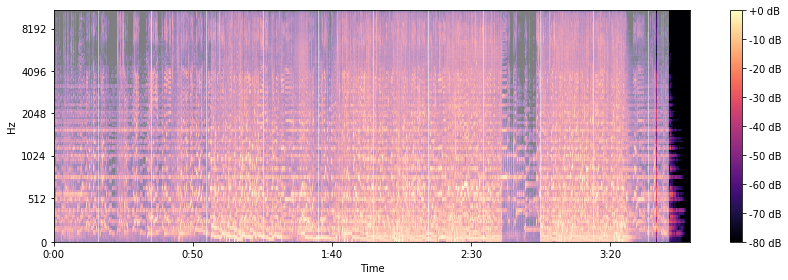

In [10]:
# Now, let's run the beat tracker.
# We'll use the percussive component for this part
plt.figure(figsize=(12, 6))
tempo, beats = librosa.beat.beat_track(y, sr=sr)

# Let's re-draw the spectrogram, but this time, overlay the detected beats
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Let's draw transparent lines over the beat frames
plt.vlines(librosa.frames_to_time(beats),
           1, 0.5 * sr,
           colors='w', linestyles='-', linewidth=2, alpha=0.5)

plt.axis('tight')

plt.colorbar(format='%+02.0f dB')

plt.tight_layout()

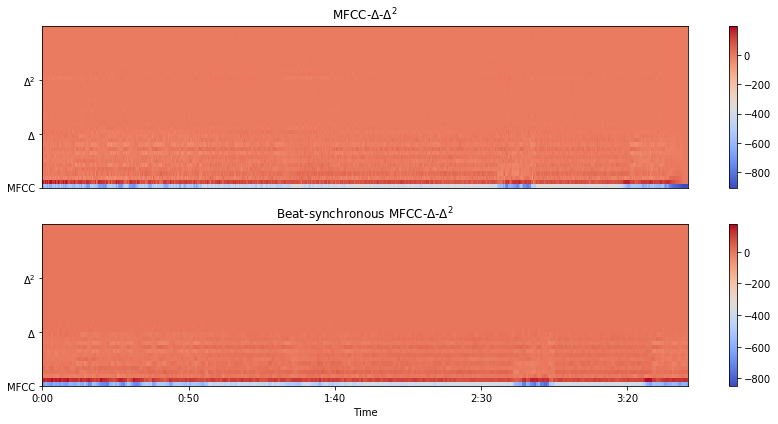

In [11]:
# feature.sync will summarize each beat event by the mean feature vector within that beat

M_sync = librosa.util.sync(M, beats)

plt.figure(figsize=(12,6))

# Let's plot the original and beat-synchronous features against each other
plt.subplot(2,1,1)
librosa.display.specshow(M)
plt.title('MFCC-$\Delta$-$\Delta^2$')

# We can also use pyplot *ticks directly
# Let's mark off the raw MFCC and the delta features
plt.yticks(np.arange(0, M.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])

plt.colorbar()

plt.subplot(2,1,2)
# librosa can generate axis ticks from arbitrary timestamps and beat events also
librosa.display.specshow(M_sync, x_axis='time',
                         x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))

plt.yticks(np.arange(0, M_sync.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])             
plt.title('Beat-synchronous MFCC-$\Delta$-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

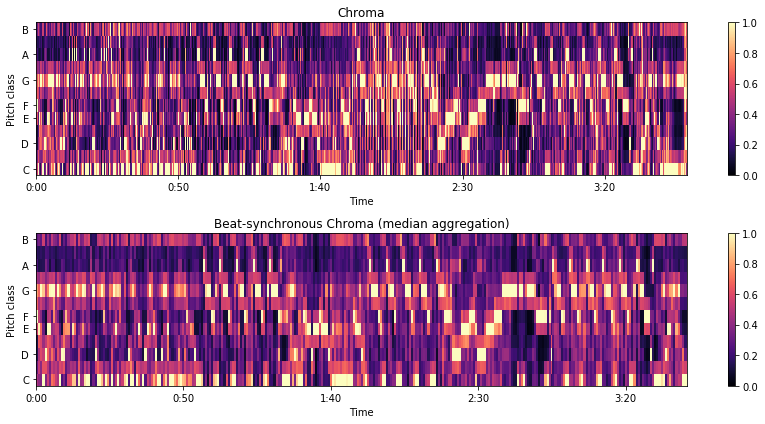

In [12]:
# Beat synchronization is flexible.
# Instead of computing the mean delta-MFCC within each beat, let's do beat-synchronous chroma
# We can replace the mean with any statistical aggregation function, such as min, max, or median.

C_sync = librosa.util.sync(C, beats, aggregate=np.median)

plt.figure(figsize=(12,6))

plt.subplot(2, 1, 1)
librosa.display.specshow(C, sr=sr, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time')

plt.title('Chroma')
plt.colorbar()

plt.subplot(2, 1, 2)
librosa.display.specshow(C_sync, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time', 
                         x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))


plt.title('Beat-synchronous Chroma (median aggregation)')

plt.colorbar()
plt.tight_layout()

In [ ]:
Beat and tempo(beats per minute) 

In [9]:
# Beat tracking example
from __future__ import print_function
import librosa

# 1. Get the file path to the included audio example
#filename = librosa.util.example_audio_file()

# 2. Load the audio as a waveform `y`
#    Store the sampling rate as `sr`
#y, sr = librosa.load(filename)

tempo1= librosa.beat.tempo(y=y, sr=sr)
print(tempo1)

tempo2= librosa.beat.tempo(y=yy, sr=srr)
print(tempo2)

# 3. Run the default beat tracker
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

print('Estimated tempo: {:.2f} beats per minute'.format(tempo))
print (tempo.shape)
# 4. Convert the frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

print(beat_times)
print('Saving output to beat_times.csv')
librosa.output.times_csv('beat_times.csv', beat_times)

[86.1328125]
[129.19921875]
Estimated tempo: 86.13 beats per minute
()
[  0.27863946   0.9752381    1.69505669   2.36843537   3.08825397
   3.78485261   4.5046712    5.20126984   5.89786848   6.61768707
   7.33750567   8.03410431   8.73070295   9.42730159  10.14712018
  10.84371882  11.56353741  12.28335601  13.0031746   13.67655329
  14.41959184  15.09297052  15.78956916  16.4861678   17.18276644
  17.87936508  18.62240363  19.31900227  20.03882086  20.7354195
  21.4552381   22.15183673  22.84843537  23.56825397  24.26485261
  24.96145125  25.68126984  26.40108844  27.09768707  27.77106576
  28.49088435  29.18748299  29.90730159  30.60390023  31.30049887
  32.02031746  32.7169161   33.43673469  34.13333333  34.85315193
  35.54975057  36.26956916  36.9661678   37.68598639  38.38258503
  39.07918367  39.77578231  40.49560091  41.2154195   41.91201814
  42.60861678  43.32843537  44.02503401  44.72163265  45.44145125
  46.13804989  46.83464853  47.55446712  48.27428571  48.97088435
  49.6

In [18]:
#Compute a chromagram from a waveform or power spectrogram.
#This implementation is derived from chromagram_E

chroma_stft=librosa.feature.chroma_stft(y=y, sr=sr)
print (chroma_stft.shape)
print (chroma_stft)

chroma_stft=librosa.feature.chroma_stft(y=yy, sr=srr)
print (chroma_stft.shape)


AttributeError: module 'librosa.feature' has no attribute 'chroma'

In [19]:
#Constant-Q chromagram
chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)
print (chroma_cq.shape)
print (chroma_cq)

(12, 9856)
[[0.21317525 0.53835637 0.63722946 ... 0.64511314 0.68816932 0.43195924]
 [0.1194802  0.52759969 0.24393918 ... 0.72122697 0.8054913  0.7032337 ]
 [0.29381825 0.46926094 0.39515003 ... 0.94422267 1.         1.        ]
 ...
 [0.18438672 0.62063509 0.27712921 ... 0.88025014 0.7232098  0.78401177]
 [0.45568666 0.87193519 0.51616813 ... 0.70536361 0.67755506 0.61415456]
 [1.         0.79535883 1.         ... 0.62909086 0.70666437 0.63971253]]


In [31]:
#Computes the chroma variant “Chroma Energy Normalized” (CENS)
chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
print (chroma_cens.shape)
print(chroma_cens)
chroma_cens=chroma_cens.reshape(1,118272)

(12, 9856)
[[0.33902276 0.33502357 0.33085756 ... 0.27055453 0.26541158 0.26013904]
 [0.27613465 0.27576075 0.27421089 ... 0.25607955 0.25508098 0.25414446]
 [0.22145327 0.2170636  0.21192879 ... 0.38196321 0.38553118 0.38905096]
 ...
 [0.20206648 0.20573497 0.20855545 ... 0.25534685 0.25450274 0.25376103]
 [0.21154381 0.20236862 0.19300566 ... 0.2850869  0.28327678 0.28125838]
 [0.33786126 0.32421363 0.31019167 ... 0.27418098 0.26987757 0.26574793]]


In [30]:
print (chroma_cens.shape)
print (chroma_cens)   

(1, 118272)
[[0.33902276 0.33502357 0.33085756 ... 0.27418098 0.26987757 0.26574793]]


In [33]:
#librosa.feature.melspectrograml
melspectrogram=librosa.feature.melspectrogram(y=y, sr=sr)
print (melspectrogram.shape)

(128, 9856)


In [13]:
#librosa.feature.mfcc
mfcc=librosa.feature.mfcc(y=y, sr=sr)
print (mfcc.shape)

mfcc=librosa.feature.mfcc(y=yy, sr=srr)
print (mfcc.shape)

(20, 9856)
(20, 8696)


In [46]:
#root-mean-square (RMS) energy
rms = librosa.feature.rmse(y=y)
print (rms.shape)
print (rms)

(1, 9856)
[[6.9553330e-06 7.1609165e-06 7.3440124e-06 ... 7.5166549e-06
  7.3799370e-06 7.1555210e-06]]


In [49]:
#spectral_centroid
cent = librosa.feature.spectral_centroid(y=y, sr=sr)
print (cent)
print (cent.shape)

[[6497.75120375 6546.70981389 6604.2032558  ... 6605.62256425
  6637.68104325 6575.22808592]]
(1, 9856)


In [50]:
# bandwidth for each frame
#returns frequency bandwidth for each frame
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
print (spec_bw.shape)

(1, 9856)


In [55]:
#spectral_contrast
#each row of spectral contrast values corresponds to a given octave-based frequency
contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
print (contrast.shape)

(7, 9856)


In [56]:
#spectral_flatness
#spectral flatness for each frame. The returned value is in [0, 1] and often converted to dB scale.

flatness = librosa.feature.spectral_flatness(y=y)
print (flatness.shape)

(1, 9856)


In [57]:
#Compute roll-off frequency.
# return roll-off frequency for each frame
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
print (rolloff.shape)
print (rolloff) 
## Approximate minimum frequencies with roll_percent=0.1
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.1)
print (rolloff.shape)
print (rolloff)

(1, 9856)
[[9700.70800781 9700.70800781 9754.54101562 ... 9743.77441406
  9733.0078125  9657.64160156]]
(1, 9856)
[[1550.390625   1550.390625   1604.22363281 ... 1571.92382812
  1668.82324219 1604.22363281]]


In [61]:
#Get coefficients of fitting an nth-order polynomial to the columns of a spectrogram.
p0 = librosa.feature.poly_features(y=y, order=0)
print (p0.shape)
print (p0)
p1 = librosa.feature.poly_features(y=y, order=1)
print (p1.shape)
print (p1)
p2 = librosa.feature.poly_features(y=y, order=2)
print (p2.shape)
print (p2.shape)

(1, 9856)
[[0.00014134 0.00015245 0.0001531  ... 0.0001674  0.00015991 0.00014537]]
(2, 9856)
[[1.37206106e-08 1.55345593e-08 1.64680844e-08 ... 1.80305148e-08
  1.77284933e-08 1.52218686e-08]
 [6.57001632e-05 6.68109002e-05 6.23149754e-05 ... 6.80095495e-05
  6.21806325e-05 6.14575661e-05]]
(3, 9856)
(3, 9856)


In [63]:
#Computes the tonal centroid features (tonnetz)
#Tonal centroid features for each frame.
tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
print (tonnetz.shape)
print (tonnetz)


(6, 9856)
[[ 5.01127088e-02 -2.01973617e-02  1.42512548e-02 ... -1.98096617e-02
  -5.06537241e-03  1.15410872e-02]
 [-1.40331824e-01  1.61867055e-02  2.09244673e-02 ...  1.59041634e-02
   6.96654297e-03 -8.83147950e-03]
 [ 2.36393865e-01 -1.58506513e-02  3.51375896e-02 ...  1.53539794e-02
   3.17788422e-02  3.10538661e-02]
 [-6.55883412e-04 -7.14269417e-02  4.17933707e-02 ... -1.17083420e-02
  -4.82154279e-02 -1.23117075e-01]
 [-7.50153072e-02 -1.55037207e-04 -7.87412230e-02 ... -1.82214030e-02
  -1.09784698e-02 -1.74778781e-02]
 [-7.48779616e-02 -7.96821018e-03 -3.98118101e-02 ...  5.67561810e-03
   2.49443233e-03  1.60844373e-02]]


In [64]:
#Compute the zero-crossing rate of an audio time series.
#zcr[0, i] is the fraction of zero crossings in the i th frame

zero = librosa.feature.'zero_crossing_rate'(y)
print (zero.shape)
print (zero)

(1, 9856)
[[0.34277344 0.52392578 0.69677734 ... 0.70068359 0.57226562 0.39208984]]


In [66]:
#Compute the tempogram: local autocorrelation of the onset strength envelope.

tempogram = librosa.feature.tempogram(y=y, sr=sr)
print (tempogram.shape)
print (tempogram)

(384, 9856)
[[ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [ 6.36099847e-01  6.36436625e-01  6.36774911e-01 ...  7.86379216e-01
   7.85207761e-01  7.84030691e-01]
 [ 2.35661902e-01  2.36543191e-01  2.37427831e-01 ...  7.35244871e-01
   7.33735108e-01  7.32209200e-01]
 ...
 [-2.26417081e-16  1.33809884e-17 -1.06117417e-16 ...  8.46159263e-16
   5.95404196e-16  6.13630633e-16]
 [-1.76787646e-17  1.78351958e-16  1.82408458e-16 ...  8.74218747e-16
   6.30115511e-16  6.46310813e-16]
 [-8.65871135e-17  3.71181418e-17  1.05959728e-16 ...  7.21748006e-16
   4.74978449e-16  5.11633950e-16]]
